In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Diagnostics in MOM6 can be on different isopynal levels. This requires us specify density levels properly such that density levels reasonable thicknesses. Similarly specifying proper density levels is important for running the model in isopycnal and hybrid modes. Here, check output from the 1/4 Deg run to identify the density range. 

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star/TS_Wright/Res_025/check_rho2/"

ds_z = xr.open_dataset(ppdir+"prog_z.nc", decode_times=False)
ds_rho = xr.open_dataset(ppdir+"prog_rho2.nc", decode_times=False)

print(ds_z)
print(ds_rho)

<xarray.Dataset>
Dimensions:     (Time: 5, nv: 2, xh: 320, xq: 320, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh          (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l         (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i         (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time        (Time) float64 1.8e+04 1.8e+04 1.8e+04 1.8e+04 1.8e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * yq          (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp        (Time, z_l, yh, xh) float32 ...
    salt        (Time, z_l, yh, xh) float32 ...
    rhopot0     (Time, z_l, yh, xh) float32 ...
    rhopot2     (Time, z_l, yh, xh) float32 ...
    u           (Time, z_l, yh, xq) float32 ...
    v           (Time, z_l, yq, xh) float32 ...
  

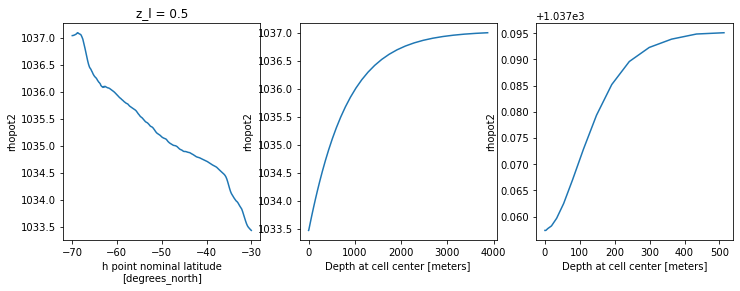

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
ds_z['rhopot2'].isel(z_l=0).mean(['xh','Time']).plot()

plt.subplot(1,3,2)
ds_z['rhopot2'].sel(yh=slice(-31.0, -30.0)).mean(['xh','yh','Time']).plot()

plt.subplot(1,3,3)
ds_z['rhopot2'].sel(yh=slice(-70.0, -69.0)).mean(['xh','yh','Time']).plot()

In [18]:
print(ds_rho['rho2_l'])

<xarray.DataArray 'rho2_l' (rho2_l: 35)>
array([1013.75    , 1028.5     , 1029.242188, 1029.71875 , 1030.179688,
       1030.625   , 1031.054688, 1031.46875 , 1031.867188, 1032.25    ,
       1032.617188, 1032.96875 , 1033.304688, 1033.625   , 1033.929688,
       1034.21875 , 1034.492188, 1034.75    , 1034.992188, 1035.21875 ,
       1035.429688, 1035.625   , 1035.804688, 1035.96875 , 1036.117188,
       1036.25    , 1036.375   , 1036.5     , 1036.625   , 1036.75    ,
       1036.875   , 1037.      , 1037.125   , 1037.25    , 1037.65625 ])
Coordinates:
  * rho2_l   (rho2_l) float64 1.014e+03 1.028e+03 ... 1.037e+03 1.038e+03
Attributes:
    units:      kg m-3
    long_name:  Target Potential Density at cell center
    axis:       Z
    positive:   down
    edges:      rho2_i


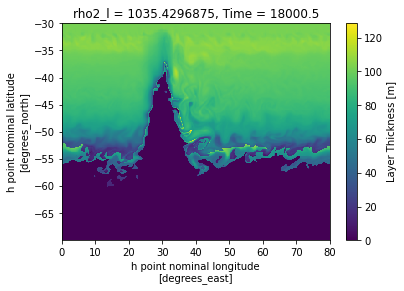

In [31]:
ds_rho['h'].isel(Time=0,rho2_l=20).plot()

In [2]:
def rho_function1(nk,rho_1,rho_2,rho_3,drho,rho_4,drho_min,plot=True):
    rho_target = np.zeros(nk+1)
    rho_target[:]=np.nan
    rho_target[0]=rho_1
    rho_target[1]=rho_2

    nki = nk+1-4
    dx = 0
    for k in range(nki+1):
        ddx = np.max([drho_min, (nki-k)/(nki*nki)])
        dx = dx + ddx
        rho_target[3-1+k] = rho_3 + (2*drho)*dx
    
    rho_target[nki+4-1]=rho_4
    
    if plot:
        plt.plot(np.diff(rho_target),(rho_target[1:]+rho_target[:-1])/2,'.')
        plt.gca().set_xlim([0,1])
        plt.gca().set_title('delta rho as a function of rho')
    
    return rho_target

[1032.         1032.4        1032.86875    1033.12910156 1033.38105469
 1033.62460937 1033.85976562 1034.08652344 1034.30488281 1034.51484375
 1034.71640625 1034.90957031 1035.09433594 1035.27070312 1035.43867187
 1035.59824219 1035.74941406 1035.8921875  1036.0265625  1036.15253906
 1036.27011719 1036.37929687 1036.48007812 1036.57246094 1036.65644531
 1036.73203125 1036.79921875 1036.85800781 1036.90839844 1036.95247344
 1036.99654844 1037.04062344 1037.08469844 1037.12877344 1037.17284844
 1037.5       ]


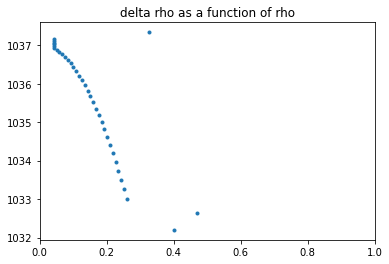

In [16]:
nk = 35
rho_1 = 1032.0
rho_2 = 1032.4
rho_3 = 1032.6
drho = 4.3
rho_4 = 1037.5
drho_min = 0.005125

rho_target = rho_function1(nk,rho_1,rho_2,rho_3,drho,rho_4,drho_min)
print(rho_target)